Geometry: NDBR50, Epoch [100/1000], Loss: 168060.6250
Geometry: NDBR50, Epoch [200/1000], Loss: 168019.0312
Geometry: NDBR50, Epoch [300/1000], Loss: 167978.5000
Geometry: NDBR50, Epoch [400/1000], Loss: 167935.7344
Geometry: NDBR50, Epoch [500/1000], Loss: 167890.8125
Geometry: NDBR50, Epoch [600/1000], Loss: 167843.4062
Geometry: NDBR50, Epoch [700/1000], Loss: 167774.6406
Geometry: NDBR50, Epoch [800/1000], Loss: 167671.4688
Geometry: NDBR50, Epoch [900/1000], Loss: 167689.4375
Geometry: NDBR50, Epoch [1000/1000], Loss: 167456.7188
Predicted parameters for geometry NDBR50:
[-0.40144315361976624, 24.220975875854492, 1.1409657001495361, 0.4030616879463196, 26.719690322875977, 23.912445068359375, 18.543712615966797]


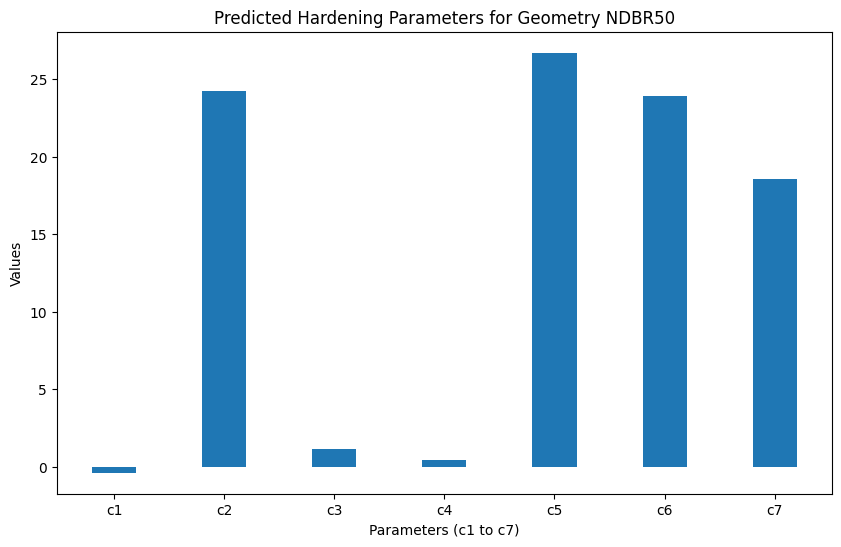

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F

# Define the geometry (you can change this to any of the geometries: 'NDBR50', 'NDBR20', 'NDBR6', 'CHD6')
geometry = 'NDBR50'
dataPoints = {'NDBR50': 50000, 'NDBR20': 50000, 'NDBR6': 50000, 'CHD6': 50000}

# Load data from CSV files
X_file = f"MODEL_DATA/NEWDATA/newData_{geometry}_FD.csv"
Y_file = "MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv"

X_data = pd.read_csv(X_file, usecols=[0, 1]).values
Y_data = pd.read_csv(Y_file).values

# Define a custom neural network model with regularization
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.LeakyReLU(negative_slope=0.01)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.relu4 = nn.LeakyReLU(negative_slope=0.01)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu_out = nn.ReLU()  #

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)  # Apply ReLU activation with threshold 0
        x = self.relu1(x)
        x = self.fc2(x)
        x = F.relu(x)  # Apply ReLU activation with threshold 0
        x = self.relu2(x)
        x = self.fc3(x)
        x = F.relu(x)  # Apply ReLU activation with threshold 0
        x = self.relu3(x)
        x = self.fc4(x)
        x = F.relu(x)  # Apply ReLU activation with threshold 0
        x = self.relu4(x)
        x = self.fc5(x)
        return x

# Custom loss function with regularization
class CustomMSELoss(nn.Module):
    def __init__(self, lambda_reg):
        super(CustomMSELoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets, target_values):
        mse_loss = nn.MSELoss()(outputs, targets)
        reg_loss = torch.mean((outputs - target_values) ** 2)
        return mse_loss + self.lambda_reg * reg_loss

input_size = 2  # Number of input parameters (force and displacement)
hidden_size1 = 64  # Number of units in the first hidden layer
hidden_size2 = 64  # Number of units in the second hidden layer
hidden_size3 = 64  # Number of units in the second hidden layer
hidden_size4 = 64  # Number of units in the second hidden layer
output_size = 7    # Number of output dimensions (c1 to c7)

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size)

# Define a loss function (custom MSE loss with regularization) and an optimizer (e.g., Adam)
criterion = CustomMSELoss(lambda_reg=0.1)  # Adjust lambda_reg as needed
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000

target_values = torch.tensor([0.5, 1300, 2.3 * 10**-14, 0.075, 773.18, 1039.37, 73.94], dtype=torch.float32)

num_samples = min(dataPoints[geometry], len(Y_data))
X_sample = torch.tensor(X_data[:num_samples], dtype=torch.float32)
Y_sample = torch.tensor(Y_data[:num_samples], dtype=torch.float32)

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_sample)

    # Compute the loss with regularization
    loss = criterion(outputs, Y_sample, target_values)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Geometry: {geometry}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

# Load the trained model for prediction
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()  # Set the model to evaluation mode

# Predict parameters for the selected geometry
X_test = torch.tensor(X_data[:1], dtype=torch.float32)
with torch.no_grad():
    predictions = model(X_test)

# Print predicted parameters for the selected geometry
print(f'Predicted parameters for geometry {geometry}:')
print(predictions[0].tolist())

# Visualize 'c1' to 'c7' values for the selected geometry
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
param_values = predictions[0].tolist()

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(param_names)), param_values, width=0.4)
plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title(f'Predicted Hardening Parameters for Geometry {geometry}')
plt.xticks(np.arange(len(param_names)), param_names)

plt.show()
